ic| side_index: tensor([[ 0, -1],
                        [ 0, -1],
                        [ 0, -1],
                        [ 1, -1],
                        [ 1, -1],
                        [ 1, -1],
                        [ 1, -1],
                        [ 0, -1]], device='cuda:0', dtype=torch.int32)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26787254..0.639353].


/home/amai/delaunay_splatting
(0.000000-2.274704) i:4@0, p:1, b(0.000000, 0.000000, 0.000000), g(0.000000, 0.000000, 0.000000)
(2.274704-2.419677) i:3@1, p:-1, b(-0.501095, 0.198264, 0.198264), g(0.012153, -0.012153, -0.012153)
Start_t: 1.314727
Max value torch: 0.6393529772758484
Max value jax: 0.56918865442276
Mean Error: 0.009672713465988636
Max Error: 0.07016432285308838
Error at 0: [-0.03299073 -0.03290299 -0.03307846]
Torch


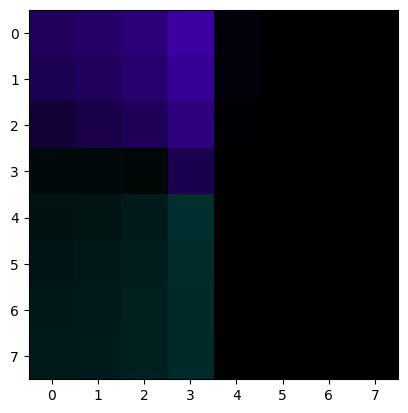

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28537318..0.56918865].


GT


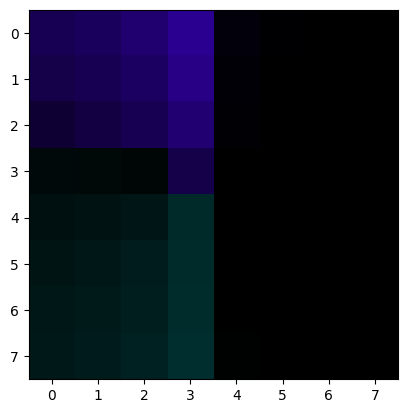

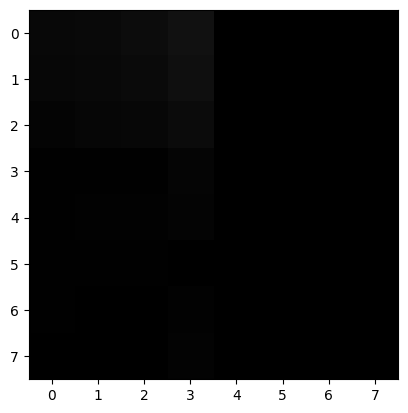

In [7]:
import os
# VERSION = 9
# if VERSION is not None:
#     os.environ["CC"] = f"/usr/bin/gcc-{VERSION}"
#     os.environ["CXX"] = f"/usr/bin/g++-{VERSION}"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from pathlib import Path
import sys
sys.path.insert(0, str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))
import math
from utils.model_util import offset_normalize
from utils.topo_utils import calculate_circumcenters_torch


import torch
from utils.compare_quad_rt import test_tetrahedra_rendering

import matplotlib.pyplot as plt
import numpy as np
from utils import topo_utils
from utils.test_util import compute_delaunay, generate_color_palette

import plotly.graph_objects as go
import numpy as np
torch.set_printoptions(precision=10)

vertices = torch.tensor([[ 2.0462048054,  6.0099563599, -2.7709932327],
        [ 9.2570934296, -3.4037013054, -0.6154882908],
        [-0.3192037344, -0.4060620070, -4.8382291794],
        [ 2.3484408855, -0.4595559835,  5.1750946045],
        [ 2.0315635204, -8.9080104828,  1.1725664139],
        [-5.5116777420, -4.8009209633, -4.7378311157],
        [-9.1555585861, -1.2241894007, -1.7154008150],
        [ 2.5718522072, -2.6496136189,  0.6982851028],
        [-0.3329432011, -1.1659097672, -2.4887781143],
        [ 1.0286951065, -5.4186248779, -1.0571700335]], device='cuda:0')
viewmat = torch.tensor([[-6.2930476665e-01, -5.1553761959e-01,  5.8154672384e-01,
          7.3674771786e-01],
        [ 8.2019373775e-02, -7.8817689419e-01, -6.0995894670e-01,
         -2.4596879959e+00],
        [ 7.7281844616e-01, -3.3615204692e-01,  5.3828763962e-01,
          1.2050601244e+00],
        [ 1.4261853920e-09, -2.2020444135e-08,  1.1744639039e-08,
          1.0000000000e+00]], device='cuda:0')
vertices = torch.tensor([[ 2.0462048054,  6.0099563599, -2.7709932327],
        [ 9.2570934296, -3.4037013054, -0.6154882908],
        [-0.3192037344, -0.4060620070, -4.8382291794],
        [ 2.3484408855, -0.4595559835,  5.1750946045],
        [ 2.0315635204, -8.9080104828,  1.1725664139],
        [-5.5116777420, -4.8009209633, -4.7378311157],
        [-9.1555585861, -1.2241894007, -1.7154008150],
        [ 2.5718522072, -2.6496136189,  0.6982851028],
        [-0.3329432011, -1.1659097672, -2.4887781143],
        [ 1.0286951065, -5.4186248779, -1.0571700335]], device='cuda:0')
viewmat = torch.tensor([[-6.2930476665e-01, -5.1553761959e-01,  5.8154672384e-01,
          6.3674771786e-01],
        [ 8.2019373775e-02, -7.8817689419e-01, -6.0995894670e-01,
         -2.4596879959e+00],
        [ 7.7281844616e-01, -3.3615204692e-01,  5.3828763962e-01,
          1.2050601244e+00],
        [ 1.4261853920e-09, -2.2020444135e-08,  1.1744639039e-08,
          1.0000000000e+00]], device='cuda:0')
tile_size = 4

def augment(v):
    return torch.cat([v, torch.ones_like(v[:, :1])], dim=-1)

indices = compute_delaunay(vertices)
indices = indices[13:15]

vols = topo_utils.tet_volumes(vertices[indices])
reverse_mask = vols < 0
if reverse_mask.sum() > 0:
    indices[reverse_mask] = indices[reverse_mask][:, [1, 0, 2, 3]]


N = indices.shape[0]
all = generate_color_palette(N*2)[:, :3]
base_colors = all[:N].reshape(-1, 3)
raw_grd = (2*all[N:].reshape(-1, 3)-1) / math.sqrt(3)
tets = vertices[indices]
circumcenters, _ = calculate_circumcenters_torch(tets)
new_color, new_grd = offset_normalize(
    base_colors, raw_grd,
    circumcenters, tets)
tet_density = torch.rand((len(indices),1), device='cuda')+ 0.2
# raw_cell_values = torch.cat([tet_density, torch.ones_like(new_color+0.5), 0*new_grd.reshape(-1, 3)], dim=1)
raw_cell_values = torch.cat([tet_density, new_color+0.0, new_grd.reshape(-1, 3)], dim=1)

results = test_tetrahedra_rendering(
    vertices.cuda(), indices, raw_cell_values, tet_density, viewmat,
    height=8, width=8, tile_size=8, fov=170, tmin=0)

print(f"Max value torch: {results['torch_image'].max()}")
print(f"Max value jax: {results['jax_image'].max()}")
print(f"Mean Error: {results['mean_error']}")
print(f"Max Error: {results['max_error']}")

print(f"Error at 0: {(results['jax_image'][..., :3] - results['torch_image'])[0, 0]}")

print("Torch")
plt.imshow(results['torch_image'])
plt.show()
print("GT")
plt.imshow(results['jax_image'][..., :3])
plt.show()
plt.imshow(np.abs(results['jax_image'][..., :3] - results['torch_image']))
plt.show()

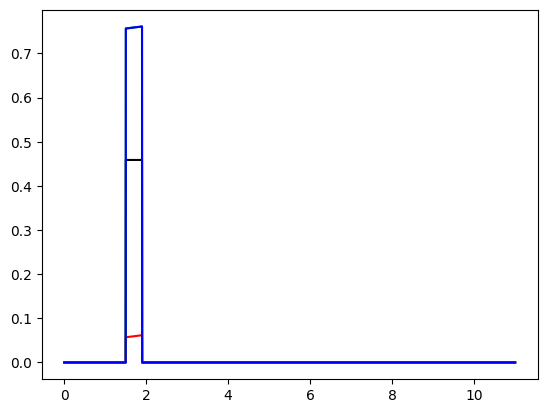

In [2]:
# print((viewmat @ circumcenters.T)[:3].T)
# print(colors, indices)
i, j = 25, 0
k = 3
qcolors = results['extras']['avg_colors'][i, j, 0]
weights = results['extras']['total_density'][i, j, 0]
tdist = results['extras']['tdist'][i, j]
N = min(tdist[tdist < 10000].shape[0], tdist.shape[0]-1)
plt.plot(tdist[:N], weights[:N], c='black')
plt.plot(tdist[:N], qcolors[:N, 0], c='red')
plt.plot(tdist[:N], qcolors[:N, 1], c='green')
plt.plot(tdist[:N], qcolors[:N, 2], c='blue')
plt.show()



In [3]:
def ray_plane_intersection(
    plane_v1: torch.Tensor,
    plane_v2: torch.Tensor,
    plane_v3: torch.Tensor,
    ray_origin: torch.Tensor,
    ray_direction: torch.Tensor,
    epsilon: float = 1e-6
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    edge1 = plane_v2 - plane_v1
    edge2 = plane_v3 - plane_v1

    plane_normal = torch.cross(edge1, edge2, dim=-1)
    denominator = torch.sum(ray_direction * plane_normal, dim=-1)

    v1_to_origin = plane_v1 - ray_origin
    numerator = torch.sum(v1_to_origin * plane_normal, dim=-1)

    t = numerator / denominator
    return t
print(vertices[indices[0]])
face_indices = torch.tensor([[7, 0, 2],
                      [2, 0, 8],
                      [8, 0, 7],
                      [7, 2, 8]], device='cuda:0', dtype=torch.uint32)
for inds in face_indices.long():
    t = ray_plane_intersection(vertices[inds][0],vertices[inds][1],vertices[inds][2],
                           torch.tensor([-0.3329430819, -1.1659097672, -2.4887781143], device='cuda:0'), torch.tensor([ 0.8829745650,  0.4090099633, -0.2303626537], device='cuda:0'))
    print(t)
    
print(
    np.array([[ 2.5718522, -2.6496136,  0.6982851], [-0.31920373, -0.406062,   -4.838229  ], [-0.3329432, -1.1659098, -2.488778 ], [ 2.0462048,  6.0099564, -2.7709932]])

)

tensor([[ 2.5718522072, -2.6496136189,  0.6982851028],
        [-0.3192037344, -0.4060620070, -4.8382291794],
        [-0.3329432011, -1.1659097672, -2.4887781143],
        [ 2.0462048054,  6.0099563599, -2.7709932327]], device='cuda:0')
tensor(1.3455554247, device='cuda:0')
tensor(-1.4894052924e-07, device='cuda:0')
tensor(-1.2164217367e-07, device='cuda:0')
tensor(-2.9472749929e-07, device='cuda:0')
[[ 2.5718522  -2.6496136   0.6982851 ]
 [-0.31920373 -0.406062   -4.838229  ]
 [-0.3329432  -1.1659098  -2.488778  ]
 [ 2.0462048   6.0099564  -2.7709932 ]]
